In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [3]:
!pip install -U spacy
!python -m spacy download fr_dep_news_trf #here model selected is french with target of accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.8/397.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-many

In [4]:
import spacy as sp

# Load the French language model
nlp = sp.load('fr_dep_news_trf')

In [5]:
sample_submission = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/sample_submission.csv")
training_data = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/training_data.csv", encoding='utf-8')
unlabelled_test_data = pd.read_csv("https://raw.githubusercontent.com/JohannG3/DS_ML/main/unlabelled_test_data.csv", encoding='utf-8')

In [6]:
training_data['difficulty'].value_counts()

difficulty
A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: count, dtype: int64

In [7]:
sample_submission.head()

,id,difficulty
0,0,A1
1,1,A1
2,2,A1
3,3,A1
4,4,A1


In [8]:
training_data.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [9]:
training_data['difficulty'].unique()

array(['C1', 'A1', 'B1', 'A2', 'B2', 'C2'], dtype=object)

In [10]:
unlabelled_test_data.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


### 1.2 KNN classifier

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from concurrent.futures import ProcessPoolExecutor

In [12]:
!pip install fast_ml --quiet
from fast_ml.model_development import train_valid_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.5 MB/s eta 0:00:00


In [13]:
def preprocess_text(text):
    doc = nlp(text)
    # Lemmatization and tokenization
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return ' '.join(preprocessed_tokens)  # Join tokens back into a sentence

# Preprocess the sentences
training_data['preprocessed_text'] = training_data['sentence'].apply(preprocess_text)

# Label encoding
label_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
training_data['encoded_difficulty'] = training_data['difficulty'].map(label_map)


In [14]:
# Split data into features and labels
X= training_data['preprocessed_text']
y= training_data['encoded_difficulty']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
# Create a pipeline with TfidfVectorizer and KNeighborsClassifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier())])

In [17]:
y_pred = pipe.predict(X_test)

In [18]:
"""
unlabelled_test_data['preprocessed_text'] = unlabelled_test_data['sentence'].apply(preprocess_text)

# Predict the difficulty levels
X_new = unlabelled_test_data['preprocessed_text']
y_pred = pipe.predict(X_new)
"""

"\nunlabelled_test_data['preprocessed_text'] = unlabelled_test_data['sentence'].apply(preprocess_text)\n\n# Predict the difficulty levels\nX_new = unlabelled_test_data['preprocessed_text']\ny_pred = pipe.predict(X_new)\n"

In [19]:
len(y_pred)

960

In [20]:
len(y_test)

960

In [21]:
# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.78      0.44       166
           1       0.22      0.29      0.25       158
           2       0.26      0.16      0.20       166
           3       0.45      0.18      0.26       153
           4       0.65      0.22      0.33       152
           5       0.58      0.36      0.44       165

    accuracy                           0.34       960
   macro avg       0.41      0.33      0.32       960
weighted avg       0.41      0.34      0.32       960



In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.33645833333333336


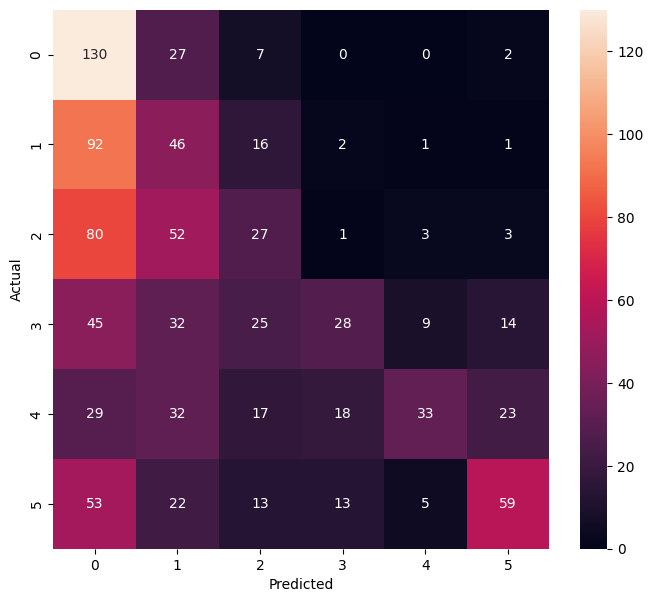

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Grid Search optimisation

In [24]:
# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and KNeighborsClassifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.75, 0.85, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_split, y_train_split)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'distance', 'tfidf__max_df': 0.75, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score:  0.3652376790868886


In [25]:
# Use the best model to make predictions on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Decode the predicted labels back to their original difficulty levels
reverse_label_map = {v: k for k, v in label_map.items()}
y_pred_original = [reverse_label_map[label] for label in y_pred]

# Evaluate the model
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.65      0.47       122
           1       0.41      0.32      0.36       138
           2       0.24      0.16      0.19       129
           3       0.43      0.16      0.23       128
           4       0.33      0.49      0.39       128
           5       0.45      0.46      0.46       123

    accuracy                           0.37       768
   macro avg       0.37      0.37      0.35       768
weighted avg       0.37      0.37      0.35       768



In [26]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3684895833333333


In [27]:
y_val_array = y_val.to_numpy()

In [28]:
df_y_val = pd.DataFrame(y_val_array, columns=['Actual'])
#df_y_pred = pd.DataFrame(y_pred, columns=['Predicted'])

df_y_val.to_csv('KNN_y_val.csv', index=False)
#df_y_pred.to_csv('KNN_y_pred.csv', index=False)

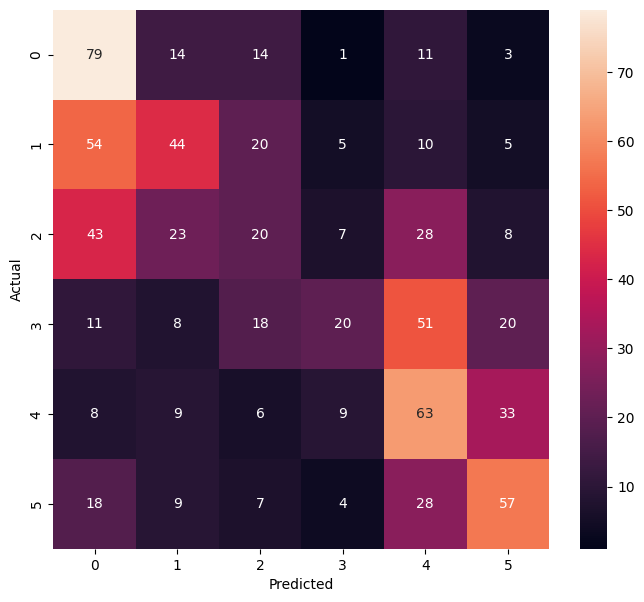

In [ ]:
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Label submission

In [ ]:
unlabelled_test_data['preprocessed_text'] = unlabelled_test_data['sentence'].apply(preprocess_text)

# Predict the difficulty levels
X_test_obj = unlabelled_test_data['preprocessed_text']
y_pred_obj = best_model.predict(X_test_obj)

In [ ]:
y_pred_obj

array([1, 2, 2, ..., 5, 4, 0])

In [ ]:
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert the predicted encoded labels back to their original labels
y_pred_original = [reverse_label_map[encoded_label] for encoded_label in y_pred_obj]


In [ ]:
sample_submission['predicted difficulty'] = y_pred_original

In [ ]:
sample_submission_fin = sample_submission.drop('difficulty', axis=1)
sample_submission_fin.head()

,id,predicted difficulty
0,0,A2
1,1,B1
2,2,B1
3,3,A2
4,4,C2
